# Mulitview YCB Dataset

In [1]:
%matplotlib inline
import os
import cv2
import numpy as np
import torch
from torch.autograd import Variable
import quat_math
import pickle

from PIL import Image
import scipy.io as scio
from functools import partial
from object_pose_utils.utils import to_np, to_var

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = 20, 12
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

## Helpful Image Viewing Functions

In [2]:
def imshowCV(img, axis = False, show = True):
    if not axis:
        plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if(show):
        plt.show()
    
def imshow(img, axis = False, colorbar = False, show = True):
    if not axis:
        plt.axis('off')
    plt.imshow(img)
    if(colorbar):
        plt.colorbar()
    if(show):
        plt.show()
    
def torch2Img(img, show = True):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    disp_img = to_np(img)
    if len(disp_img.shape) == 4:
        disp_img = disp_img[0]
    disp_img = disp_img.transpose((1,2,0))
    disp_img = disp_img * std + mean
    return disp_img
    
def imshowTorch(img, axis = False, show = True):
    if not axis:
        plt.axis('off')
    disp_img = torch2Img(img)
    plt.imshow(disp_img.astype(np.uint8))
    if(show):
        plt.show()

def plotImageScatter(img, choose, show = True):
    coords = np.unravel_index(choose, img.shape[:2])    
    plt.axis('off')
    plt.imshow(img.astype(np.uint8))    
    plt.scatter(coords[1], coords[0], 50)
    #plt.colorbar()
    if(show):
        plt.show()

In [3]:
from quat_math import quat2AxisAngle

def quats2Point(quats):
    pts = []
    for q in quats:
        xi, theta = quat2AxisAngle(q)
        pts.append(xi*theta)
    return np.array(pts)

def scatterSO3(vertices, vals, q_gt = None, alpha_max = 1.0):
    c = cmap(vals)
    a = np.maximum(0,np.minimum(1, (vals - min(vals))/(max(vals) - min(vals))))
    c[:,3] = alpha_max*a

    pts = quats2Point(vertices)
    ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=a*10, c=c)

    if(q_gt is not None):
        pt_gt = quats2Point(q_gt)
        ax.scatter(pt_gt[:,0], pt_gt[:,1], pt_gt[:,2], c='r', marker='x')

## Location of YCB Dataset

In [4]:
dataset_root = '/ssd0/datasets/ycb/YCB_Video_Dataset'
#dataset_root = '/home/bokorn/data/ycb/debug/'

## Select Object Indices of Interest

| Object Indices |[]()|[]()|
|---|---|---|
| __1.__ 002_master_chef_can | __8.__ 009_gelatin_box      | __15.__ 035_power_drill       |
| __2.__ 003_cracker_box     | __9.__ 010_potted_meat_can  | __16.__ 036_wood_block        |
| __3.__ 004_sugar_box       | __10.__ 011_banana          | __17.__ 037_scissors          |
| __4.__ 005_tomato_soup_can | __11.__ 019_pitcher_base    | __18.__ 040_large_marker      |
| __5.__ 006_mustard_bottle  | __12.__ 021_bleach_cleanser | __19.__ 051_large_clamp       |
| __6.__ 007_tuna_fish_can   | __13.__ 024_bowl            | __20.__ 052_extra_large_clamp |
| __7.__ 008_pudding_box     | __14.__ 025_mug             | __21.__ 061_foam_brick        |

In [5]:
object_list = [1]

## Select Dataset
Modes include train, syn, grid, valid, test and can be concatinated with "\_", e.g. "train\_syn"

In [6]:
mode = "valid"

## Select Output Data Types

In [7]:
from object_pose_utils.datasets.pose_dataset import OutputTypes as otypes

output_format = [otypes.OBJECT_LABEL,
                 otypes.QUATERNION, 
                 otypes.IMAGE_CROPPED, 
                 otypes.DEPTH_POINTS_MASKED_AND_INDEXES]

## Initialize YCB Dataset

In [8]:
from object_pose_utils.datasets.ycb_dataset import YcbDataset as YCBDataset
from object_pose_utils.datasets.image_processing import ImageNormalizer

ycb_dataset = YCBDataset(dataset_root, mode=mode, 
                         object_list = object_list, 
                         output_data = output_format, 
                         postprocessors = [ImageNormalizer()],
                         image_size = [640, 480], num_points=1000)

## Select Image Set Parameters
Inteval between images and max number of images

In [9]:
interval = 100
video_len = 3

## Initialize YCB Dataset

In [10]:
from object_pose_utils.datasets.ycb_video_dataset import YcbVideoDataset as YCBVideoDataset

dataset = YCBVideoDataset(ycb_dataset, 
                          interval = interval, 
                          video_len = video_len)

## Select Object If Mutiple Objects Are Avalible

In [11]:
print('Avalible objects: {}'.format(' ,'.join(str(v) for v in dataset.getObjectIds())))
object_id = object_list[0]
dataset.setObjectId(object_id)

Avalible objects: 1


## Select Video Id

In [13]:
print('Avalible Videos: {}'.format(', '.join(str(v) for v in dataset.getVideoIds())))
video_id = '0040'
#video_id = '0069'
dataset.setVideoId(video_id)
print('{} image sets avaible in video {}'.format(len(dataset), video_id))

Avalible Videos: 0040, 0091
2392 image sets avaible in video 0040


## Sample Dataset

In [14]:
# Iterate over the dataset

for data, trans in dataset:
    break

# Or if you want to grab a specific index
#idx = 0
#data, trans = dataset.__getitem__(idx)
#data = dataset.getData(idx)
#trans = dataset.getCameraTransforms(idx)

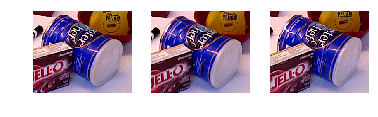

In [15]:
n = len(data)
for j, (mat, d) in enumerate(zip(trans, data)):
    plt.subplot(1,n,j+1)
    imshowTorch(d[2], show=False)
    
plt.show()

## Apply Transforms

In [16]:
from object_pose_utils.utils.multi_view_utils import applyTransform, computeCameraTransform

quats = []
for mat, d in zip(trans, data):
    quats.append(d[1])

quats_trans = applyTransform(quats, trans)

## Resulting Error

In [17]:
from object_pose_utils.utils.pose_processing import quatAngularDiff
q0 = to_np(data[0][1])
for q, q_t in zip(quats, quats_trans):
    dq = quatAngularDiff(q0, q)*180/np.pi
    dq_t = quatAngularDiff(q0, q_t)*180/np.pi
    print("{} -> {}".format(dq, dq_t))


0.0 -> 0.0
3.443573177355113 -> 0.08853007367777847
5.585295847138174 -> 0.0


## Using with DenseFusion Estimator

### Initialize Pose Estimator

In [18]:
from dense_fusion.network import PoseNetGlobal, PoseNet

#model_checkpoint = '/home/bokorn/src/DenseFusion/trained_checkpoints/ycb/pose_model_train_split_34_0.025648579025031315.pth'
#estimator = PoseNet(num_points = 1000, num_obj = 21)
#estimator.load_state_dict(torch.load(model_checkpoint, map_location=lambda storage, loc: storage))
#estimator.cuda();

model_checkpoint = '/home/bokorn/src/DenseFusion/trained_checkpoints/ycb/pose_model_global_13_0.02780649198161978.pth'
estimator = PoseNetGlobal(num_points = 1000, num_obj = 21)
estimator.load_state_dict(torch.load(model_checkpoint, map_location=lambda storage, loc: storage))
estimator.cuda();

### Init Feature Uncertainty Estimator

In [19]:
comp_model_checkpoint = '/scratch/bokorn/results/dense_fusion_global_weights/002_master_chef_can/checkpoint_45000.pth'

from generic_pose.models.compare_networks import SigmoidCompareNet

feature_size = 1024
estimator_comp = SigmoidCompareNet(feature_size, 1)
estimator_comp.load_state_dict(torch.load(comp_model_checkpoint))
estimator_comp.cuda()

feature_root = '/scratch/bokorn/results/dense_fusion_global_feat/'
grid_vertices = torch.load(os.path.join(feature_root, 'grid',
    '{}_vertices.pt'.format(ycb_dataset.classes[object_id])))
grid_features = torch.load(os.path.join(feature_root, 'grid',
    '{}_features.pt'.format(ycb_dataset.classes[object_id])))

grid_size = grid_vertices.shape[0]
grid_features = to_var(grid_features)
rep_indices = np.repeat(np.arange(1), grid_size)

## Estimate rotation for each image

In [20]:
est_quats = []
est_conf = []
est_dists = []
feats = []
for mat, d in zip(trans, data):
    idx, quat, img, points, choose, = d
    idx = idx - 1
    points, choose, img, idx = Variable(points.unsqueeze(0)).cuda(), \
                               Variable(choose.unsqueeze(0)).cuda(), \
                               Variable(img.unsqueeze(0)).cuda(), \
                               Variable(idx.unsqueeze(0)).cuda()
    
    pred_r, pred_t, pred_c, emb = estimator(img, points, choose, idx)
    feat = estimator.globalFeature(img, points, choose, idx)
    feats.append(feat)
    
    pred_q = pred_r[0,torch.argmax(pred_c)][[1,2,3,0]]
    pred_q /= pred_q.norm()
    est_quats.append(pred_q)
    est_conf.append(float(pred_c))
    
    dist_est = estimator_comp(grid_features, feat[rep_indices])
    est_dists.append(to_np(dist_est.flatten()))
    
    
est_quats_trans = applyTransform(est_quats, trans)

/home/bokorn/src/generic_pose/bpy/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/bokorn/src/generic_pose/bpy/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/bokorn/src/generic_pose/bpy/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/bokorn/src/generic_pose/bpy/lib/python3.6/site-packages/torch

## Resulting Error

In [21]:
#q0 = to_np(est_quats[0])
q0 = to_np(data[0][1])

for q, q_t in zip(est_quats, est_quats_trans):
    dq = quatAngularDiff(q0, to_np(q))*180/np.pi
    dq_t = quatAngularDiff(q0, q_t)*180/np.pi
    print("{} -> {}".format(dq, dq_t))


48.2585377992374 -> 48.258525315605496
50.96509590323927 -> 49.45040010194286
59.154714412933565 -> 55.28840915332214


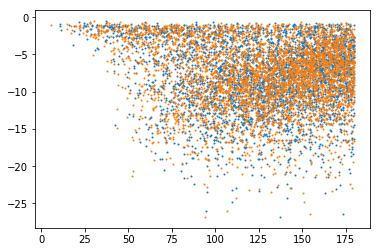

0.7577380266232531
tensor([0.3689], device='cuda:0', grad_fn=<SelectBackward>)


tensor([0.6193], device='cuda:0', grad_fn=<SelectBackward>)

In [23]:
from object_pose_utils.utils.pose_processing import tensorAngularDiff

idx = 2


vert_dist_est = to_np(tensorAngularDiff(grid_vertices.cuda(), est_quats[idx]))*180/np.pi
vert_dist = to_np(tensorAngularDiff(grid_vertices, data[idx][1]))*180/np.pi

plt.scatter(vert_dist_est, np.log(est_dists[idx]), s=1, label = 'DenseFusion Distance')
plt.scatter(vert_dist, np.log(est_dists[idx]), s=1, label = 'True Distance')
#plt.legend()
plt.show()

gt_idx = np.argmin(vert_dist)
print(np.exp(-np.min(vert_dist)/(180./9)))
print(dist_est[gt_idx])
max(dist_est)

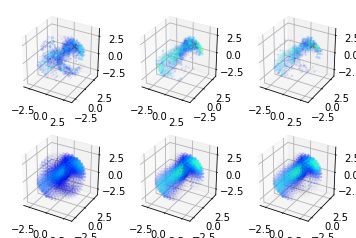

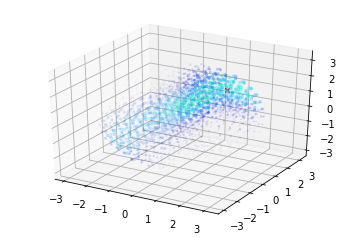

In [27]:
from object_pose_utils.utils.interpolation import BinghamInterpolation
from mpl_toolkits.mplot3d import Axes3D
cmap = plt.get_cmap('jet')
fig = plt.figure()
num_ests = len(est_dists)
conf_weights = np.array(est_conf)/sum(est_conf)

p_trans = torch.zeros(grid_size).cuda()
for j, (mat, v, w, d) in enumerate(zip(trans, est_dists, conf_weights, data)):
    ax = fig.add_subplot(2,num_ests,j+1, projection='3d')
    verts_trans = applyTransform(grid_vertices, [mat]*grid_vertices.shape[0])
    q_gt_trans = applyTransform([d[1]], [mat])
    scatterSO3(verts_trans, v, q_gt_trans, alpha_max = .5)
    
    grid_vertices_inv = applyTransform(grid_vertices, [np.linalg.inv(mat)]*grid_vertices.shape[0])
    bing_interp = BinghamInterpolation(grid_vertices_inv, torch.Tensor(v).cuda(), sigma=10)
    
    v_interp = bing_interp(torch.Tensor(grid_vertices_inv).cuda())
    p_trans += w*v_interp

    q_gt_trans = applyTransform([d[1]], [mat])

    ax = fig.add_subplot(2,num_ests,j+num_ests+1, projection='3d')
    scatterSO3(to_np(grid_vertices), to_np(v_interp), q_gt_trans, alpha_max = .5)
    
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatterSO3(to_np(grid_vertices), to_np(p_trans), [to_np(data[0][1])], alpha_max = .5)
plt.show()

In [ ]:
vert_dist[torch.argmax(p_trans)]

In [ ]:
from object_pose_utils.utils.interpolation import TetraInterpolation, BinghamInterpolation

tetra_interp = TetraInterpolation(2)

In [ ]:
grid_vertices_inv

In [ ]:
tetra_interp.setValues(est_dists[1])
grid_vertices_inv = applyTransform(grid_vertices, [np.linalg.inv(mat)]*grid_vertices.shape[0])

In [ ]:
from tqdm import tqdm_notebook as tqdm
d_inv = [tetra_interp(v_i) for v_i in tqdm(grid_vertices_inv)]